# Diabetes Prediction

# Contents <a id='back'></a>

* [1. Introduction](#intro)
* [2. Initialisation](#init)
* [3. Data Exploration and Preprocessing](#data_exploration)
* [4. Exploratory Data Analysis (EDA)](#eda)
* [5. Modeling](#modeling)
* [6. Model Evaluation](#evaluation)
* [7. Conclusion](#conclusion)

##  1. Introduction <a id='intro'></a>

Diabetes is a chronic disease that occurs either when the pancreas does not produce enough insulin or when the body cannot effectively use the insulin it produces. Insulin is a hormone that regulates blood glucose. Hyperglycaemia, also called raised blood glucose or raised blood sugar, is a common effect of uncontrolled diabetes and over time leads to serious damage to many of the body's systems, especially the nerves and blood vessels.

According to World Health Organization (WHO), 
- The number of people with diabetes rose from 108 million in 1980 to 422 million in 2014. Prevalence has been rising more rapidly in low- and middle-income countries than in high-income countries.
- Diabetes is a major cause of blindness, kidney failure, heart attacks, stroke and lower limb amputation.
- Between 2000 and 2019, there was a 3% increase in diabetes mortality rates by age.
- In 2019, diabetes and kidney disease due to diabetes caused an estimated 2 million deaths.

In conclusion, diabetes poses a substantial global health burden, necessitating comprehensive and collaborative efforts to address its prevalence, associated complications, and mortality rates. It is crucial to prioritise preventative measures, early diagnosis, and accessible healthcare to mitigate the impact of diabetes on individuals and communities worldwide.

## 1.1 Purpose

This project aims to build a classification model to detect diabetes for early diagnosis.

[Back to Contents](#back)

## 2. Initialisation <a id='init'></a>

In [1]:
# Data manipulation and preprocessing
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from lightgbm import plot_importance
from tqdm.auto import tqdm

# Classification models
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import LearningRateScheduler

import torch
from torch import nn
from torch.optim.lr_scheduler import _LRScheduler
from torchmetrics import Accuracy, ConfusionMatrix
from torch.utils.data import TensorDataset, DataLoader

# Model evaluation and selection
from sklearn.metrics import accuracy_score, confusion_matrix
from optunaopt import sklearn_opt
import pickle

[Back to Contents](#back)

## 3. Data Exploration and Preprocessing <a id='data_exploration'></a>

In [2]:
# Load the dataset
df = pd.read_csv('diabetes_prediction_dataset.csv')

In [3]:
# Check the first five rows
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [4]:
# Check the shape
df.shape

(100000, 9)

The dataset has 100000 rows (respondents) and 9 columns of information related to diabetes prediction.

**Description of data**

*Features*
- `gender`: The gender of the individual.
- `age`: The age of the individual.
- `Hypertension`: A binary indicator that signifies whether the individual has hypertension (high blood pressure).
- `heart_disease`: A binary indicator that indicates whether the individual has a history of heart disease.
- `smoking_history`: A category variable which indicates whether the individual is currently a smoker.
- `bmi`: Stands for body mass index, a measure of body fat based on the height and weight, providing insights into the individual's weight status.
- `HbA1c_level`: Represents the level of HbA1c, a glycated hemoglobin that reflects average blood glucose levels over the past few months. This is a crucial marker for diabetes management.
- `blood_glucose_level`: Indicates the current blood glucose level, which is a key parameter in diabetes diagnosis and monitoring.

*Target*
- `diabetes`: The target variable which indicates whether the individual has diabetes or not.ence of diabetes.


In [5]:
# Check for duplicates
df.duplicated().sum()

3854

In [6]:
# Check if there is any missing value
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [7]:
# Check the data types
df.dtypes

gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object

The dataset has no missing values and the data types are correct. However, there are 3854 duplicated records. Let's drop the duplicates.

In [8]:
# Drop the duplicates
df.drop_duplicates(inplace=True)

# Check if the duplicates have been drop
df.duplicated().sum()

0

In [9]:
# Check the unique values of the `smoking_history` column
df['smoking_history'].unique()

array(['never', 'No Info', 'current', 'former', 'ever', 'not current'],
      dtype=object)

Since the categorical values `former`, `ever`, `not current` have the same meaning, we can convert all of these into `former`.

In [10]:
# Replace ever and not current with former
df['smoking_history'].replace(['ever', 'not current'], 'former', inplace=True)

In [11]:
# Check the value counts of the smoking history column
df['smoking_history'].value_counts()

smoking_history
never      34398
No Info    32887
former     19664
current     9197
Name: count, dtype: int64

In [12]:
# Check the statistical summary
df.describe(include='all')

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
count,96146,96146.000000,96146.000000,96146.000000,96146,96146.000000,96146.000000,96146.000000,96146.000000
unique,3,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN
top,Female,NaN,NaN,NaN,never,NaN,NaN,NaN,NaN
freq,56161,NaN,NaN,NaN,34398,NaN,NaN,NaN,NaN
mean,NaN,41.794326,0.077601,0.040803,NaN,27.321461,5.532609,138.218231,0.088220
std,NaN,22.462948,0.267544,0.197833,NaN,6.767716,1.073232,40.909771,0.283616
min,NaN,0.080000,0.000000,0.000000,NaN,10.010000,3.500000,80.000000,0.000000
25%,NaN,24.000000,0.000000,0.000000,NaN,23.400000,4.800000,100.000000,0.000000
50%,NaN,43.000000,0.000000,0.000000,NaN,27.320000,5.800000,140.000000,0.000000
75%,NaN,59.000000,0.000000,0.000000,NaN,29.860000,6.200000,159.000000,0.000000


All of the columns have no obvious anomalies or outliers, except the gender column which has three values. Let's have a check.

In [13]:
# Check the value counts of gender
df['gender'].value_counts()

gender
Female    56161
Male      39967
Other        18
Name: count, dtype: int64

There are 18 values of `other` in `gender`, which is considered as normal.

In [14]:
# Check the value counts of the target variable
df['diabetes'].value_counts()

diabetes
0    87664
1     8482
Name: count, dtype: int64

In [15]:
# Find the percentages of each values in the target variable
df['diabetes'].value_counts(normalize=True)

diabetes
0    0.91178
1    0.08822
Name: proportion, dtype: float64

The dataset has severe class imbalance issue, which will be adressed later.

[Back to Contents](#back)

## 4. Exploratory Data Analysis (EDA) <a id='eda'></a>

In [16]:
# List the numerical and categorical features for eda
numerical_features = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
categorical_features = ['gender', 'hypertension', 'heart_disease', 'smoking_history']

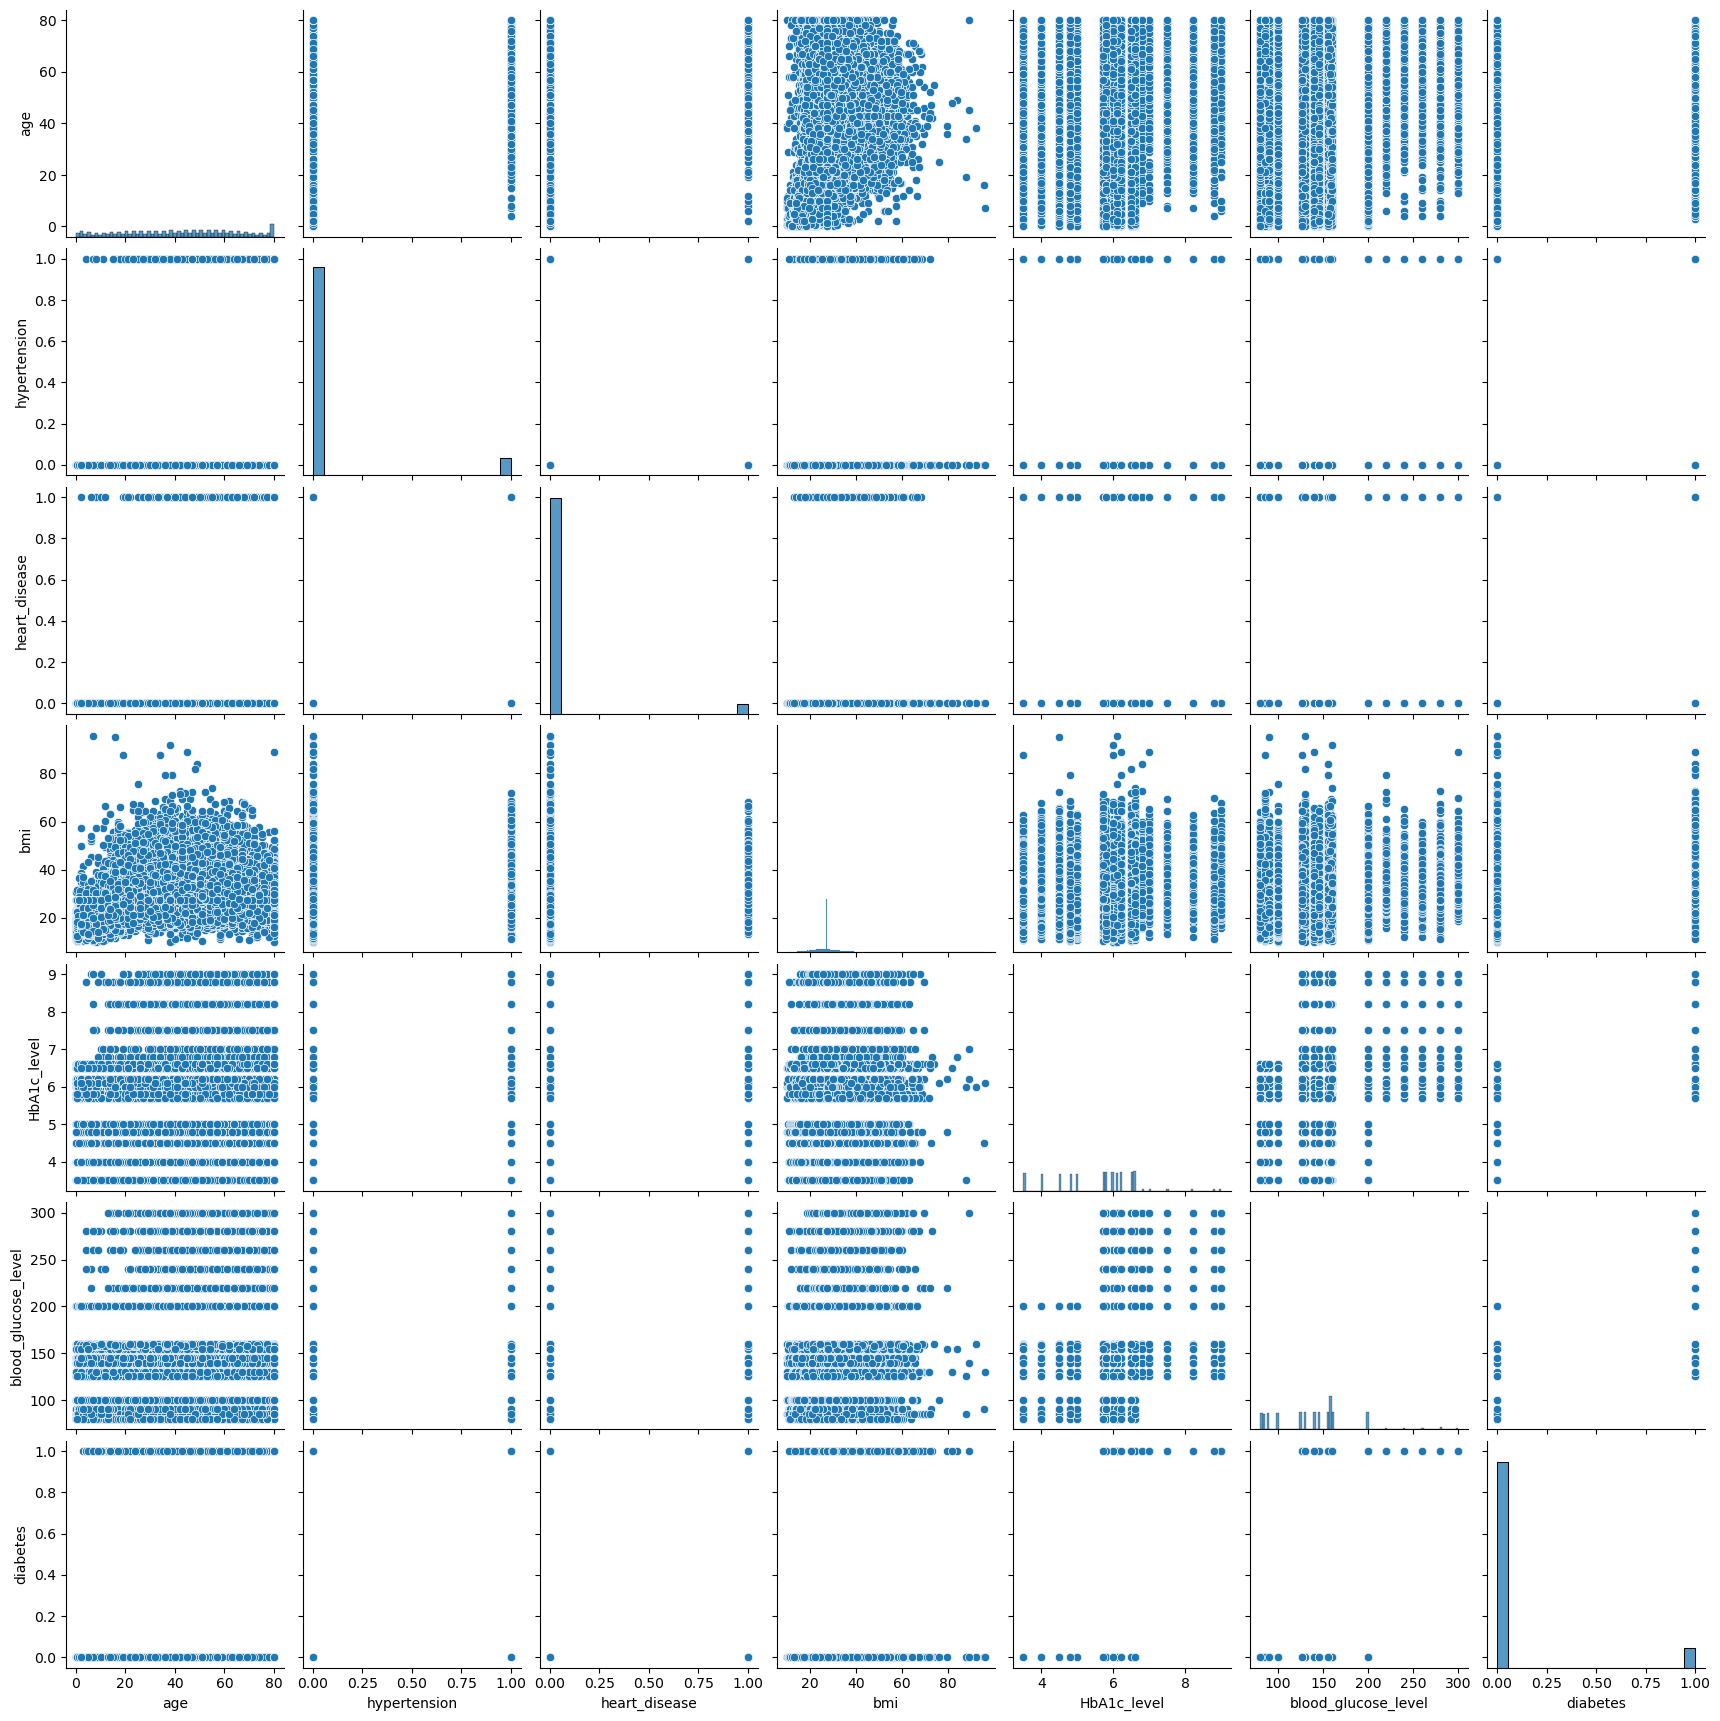

In [17]:
# Have a look at the pairplot
sns.pairplot(df);

From the pairplot, it can be seen that the higher the `HbA1c_level` and `blood_glucose_level`, the higher the chance from suffering diabetes. Besides that, the `hypertension` and `heart_disease` are likely associated with `diabetes` since these three columns have similar ratios of `0` to `1`.

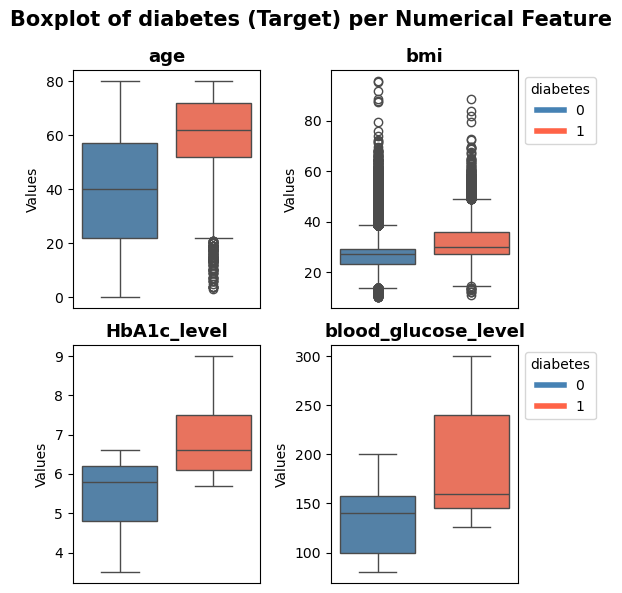

In [18]:
# Plot the boxplots to show the relationships between numerical features and the target
nrows, ncols = 2, 2
target = 'diabetes'
target_labels = ['0', '1']
palette = ['steelblue', 'tomato']

fig, axs = plt.subplots(nrows, ncols, figsize=(6, 6))

plt.suptitle(f'Boxplot of {target} (Target) per Numerical Feature',
             fontsize=15, fontweight='bold')

for i in range(nrows):
    for j in range(ncols):
        col_idx = i*ncols + j
        if col_idx < len(numerical_features):
            ax = axs[i][j]
            sns.boxplot(data=df, x=target, y=numerical_features[col_idx], hue=target,
                        palette=palette, legend=False, ax=ax)        
            ax.set_title(numerical_features[col_idx], fontsize=13, fontweight='bold')
            ax.set_xlabel('')
            ax.set_ylabel('Values')
            ax.set_xticks([])
            if j == 1:
                legend_labels = target_labels
                legend_handles = [Line2D([0], [0], color=palette[0], lw=4), Line2D([0], [0], color=palette[1], lw=4)]
                ax.legend(legend_handles, legend_labels, title=target, loc='upper left', bbox_to_anchor=(1,1))

plt.tight_layout()
plt.show()

From the boxplots, we can conclude that the `age` is an excellent predictor for `diabetes` and the other three features are also have good predictors.

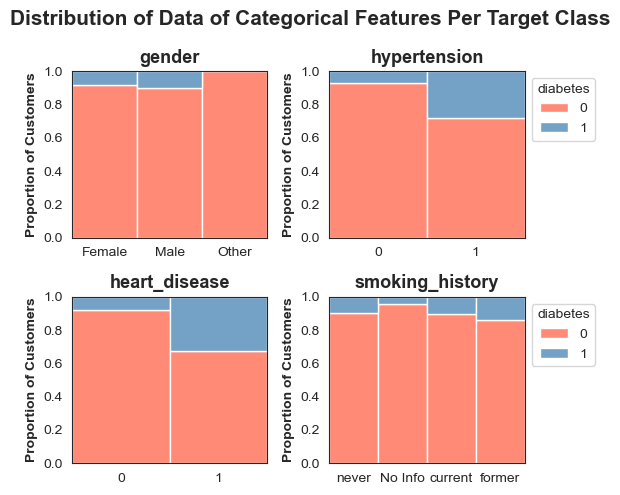

In [19]:
# Plot fill barcharts for the categorical features per target class
nrows, ncols = 2, 2
target = 'diabetes'
target_labels = ['0', '1']
palette = ['steelblue', 'tomato']

sns.set_style('white')
fig, axs = plt.subplots(nrows, ncols, figsize=(6, 5))

for i in range(nrows):
    for j in range(ncols):
        ax = axs[i][j]
        sns.histplot(data=df, x=categorical_features[i*2 + j], hue=target, hue_order=[1, 0],
                     multiple='fill', palette=palette, discrete=True, ax=ax)
        ax.set_title(categorical_features[i*2 + j], fontsize=13, fontweight='bold')
        ax.set_xlabel('')
        ax.set_ylabel('Proportion of Customers', fontweight='bold')
        if j == 1:
            ax.legend(title=target, labels=target_labels, loc='upper left', bbox_to_anchor=(1,1))
        else:            
            ax.get_legend().remove()

plt.suptitle('Distribution of Data of Categorical Features Per Target Class',
             fontsize=15, fontweight='bold')

axs[0][1].set_xticks([0, 1], [0, 1])
axs[1][0].set_xticks([0, 1], [0, 1])

plt.tight_layout()
plt.show()

From the filled barcharts, it can be seen that the `hypertension` and `heart_disease` are good predictors.

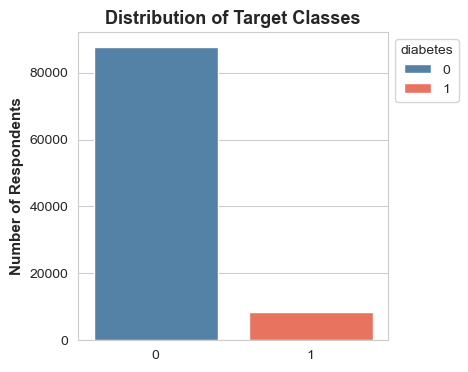

In [20]:
# Show the distribution of target classes
sns.set_style('whitegrid')
plt.figure(figsize=(4, 4))

sns.countplot(data=df, x='diabetes', hue='diabetes', palette=['steelblue', 'tomato'])
plt.title('Distribution of Target Classes', fontsize=13, fontweight='bold')
plt.xlabel('')
plt.ylabel('Number of Respondents', fontsize=11, fontweight='bold')
plt.legend(title='diabetes', loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

As mentioned above, the dataset has imbalanced classes.

[Back to Contents](#back)

## 5. Modeling <a id='modeling'></a>

The following models will be developed

- Logistic Regression
- LightGBM
- Neural Network

The performance of the model with be evaluate by the accuracy score.

In [21]:
# One-hot encode the categorical features
df_ohe = pd.get_dummies(df, dtype=int)

In [22]:
# Get the features and target
X = df_ohe.drop(columns=['diabetes'])
X_lgbm = df.drop(columns=['diabetes'])
X_lgbm[categorical_features] = X_lgbm[categorical_features].astype('category')
y = df_ohe['diabetes']

In [23]:
# Split the dataset into train:val:test = 70:15:15
X_train, X_test, X_train_lgbm, X_test_lgbm, y_train, y_test = train_test_split(
    X, X_lgbm, y, test_size=0.15, random_state=42
)
X_train, X_val, X_train_lgbm, X_val_lgbm, y_train, y_val = train_test_split(
    X_train, X_train_lgbm, y_train, test_size=3/17, random_state=42
)
print('Shape of X_train:', X_train.shape)
print('Shape of X_train_lgbm:', X_train_lgbm.shape)
print('Shape of y_train:', y_train.shape)
print()
print('Shape of X_val:', X_val.shape)
print('Shape of X_val_lgbm:', X_val_lgbm.shape)
print('Shape of y_val:', y_val.shape)
print()
print('Shape of X_test:', X_test.shape)
print('Shape of X_test_lgbm:', X_test_lgbm.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train: (67302, 13)
Shape of X_train_lgbm: (67302, 8)
Shape of y_train: (67302,)

Shape of X_val: (14422, 13)
Shape of X_val_lgbm: (14422, 8)
Shape of y_val: (14422,)

Shape of X_test: (14422, 13)
Shape of X_test_lgbm: (14422, 8)
Shape of y_test: (14422,)


In [24]:
# Check the target classes of training sets
print('Majority class count:', len(y_train[y_train == 0]))
print('Minority class count:', len(y_train[y_train == 1]))

Majority class count: 61397
Minority class count: 5905


In [25]:
# Separte the data into majority class and minority class
X_major = X_train[y_train == 0]
X_minor = X_train[y_train == 1]

X_lgbm_major = X_train_lgbm[y_train == 0]
X_lgbm_minor = X_train_lgbm[y_train == 1]

y_major = y_train[y_train == 0]
y_minor = y_train[y_train == 1]

In [26]:
# Determine the upsize and upsampling the minority class
upsize = X_major.shape[0]
X_minor_up = X_minor.sample(n=upsize, replace=True, random_state=42)
X_lgbm_minor_up = X_lgbm_minor.sample(n=upsize, replace=True, random_state=42)
y_minor_up = y_minor.sample(n=upsize, replace=True, random_state=42)

In [27]:
# Combine the majority class and upsized minority class
X_train_up = pd.concat([X_major, X_minor_up])
X_train_lgbm_up = pd.concat([X_lgbm_major, X_lgbm_minor_up])
y_train_up = pd.concat([y_major, y_minor_up])

In [28]:
# Shuffle the result
X_train_up, X_train_lgbm_up, y_train_up = shuffle(X_train_up, X_train_lgbm_up, y_train_up, random_state=42)

In [29]:
# Have a check on the result
display(X_train_up.head(3))
display(X_train_lgbm_up.head(3))
display(y_train_up.head(3))

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,gender_Female,gender_Male,gender_Other,smoking_history_No Info,smoking_history_current,smoking_history_former,smoking_history_never
74657,30.0,0,0,22.80,6.5,85,1,0,0,0,0,0,1
5963,42.0,0,0,27.32,6.5,159,0,1,0,0,0,1,0
83610,54.0,0,0,31.72,6.6,145,0,1,0,1,0,0,0


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level
74657,Female,30.0,0,0,never,22.80,6.5,85
5963,Male,42.0,0,0,former,27.32,6.5,159
83610,Male,54.0,0,0,No Info,31.72,6.6,145


74657    0
5963     0
83610    1
Name: diabetes, dtype: int64

In [30]:
# Have a look at the target class count
y_train_up.value_counts()

diabetes
0    61397
1    61397
Name: count, dtype: int64

In [31]:
# Normalise the numerical features
sc = StandardScaler()
X_train_up[numerical_features] = sc.fit_transform(X_train_up[numerical_features])
X_val[numerical_features] = sc.transform(X_val[numerical_features])
X_test[numerical_features] = sc.transform(X_test[numerical_features])

sc_lgbm = StandardScaler()
X_train_lgbm_up[numerical_features] = sc_lgbm.fit_transform(X_train_lgbm_up[numerical_features])
X_val_lgbm[numerical_features] = sc_lgbm.transform(X_val_lgbm[numerical_features])
X_test_lgbm[numerical_features] = sc_lgbm.transform(X_test_lgbm[numerical_features])

In [32]:
# Have a check on the train features
display(X_train_up[:2])
display(X_train_lgbm_up.head(2))

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,gender_Female,gender_Male,gender_Other,smoking_history_No Info,smoking_history_current,smoking_history_former,smoking_history_never
74657,-0.952994,0,0,-0.887761,0.263065,-1.373095,1,0,0,0,0,0,1
5963,-0.396225,0,0,-0.286188,0.263065,-0.079307,0,1,0,0,0,1,0


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level
74657,Female,-0.952994,0,0,never,-0.887761,0.263065,-1.373095
5963,Male,-0.396225,0,0,former,-0.286188,0.263065,-0.079307


### 4.1 Logistic Regression

Model 1 - Logistic Regression

In [33]:
# Dicts to store various information for later use
result = {}
best_model = {}

# Create a folder to store the model
model_folder = 'models'
os.makedirs(model_folder, exist_ok=True)

In [34]:
# Set up for the modeling process
model_name = 'LogisticRegression'
model_path = os.path.join(model_folder, f'{model_name}.pkl')

In [35]:
# Train and evaluate the model
lr = LogisticRegression()
lr.fit(X_train_up, y_train_up)
val_acc = accuracy_score(lr.predict(X_val), y_val)
val_acc = val_acc.mean()

# Show the validation MAE score
print(f'The validation accuracy score of {model_name}: {val_acc:.4f}')

The validation accuracy score of LogisticRegression: 0.8826


In [36]:
# Store the result
result[model_name] = {}
result[model_name]['val_acc'] = val_acc
best_model[model_name] = lr

# Delete the model if it exists
if os.path.isfile(model_path):
    os.remove(model_path)

# Save the model
pickle.dump(best_model[model_name], open(model_path, 'wb'))
if os.path.isfile(model_path):
    print(f'The {model_name} model has been saved.')

The LogisticRegression model has been saved.


### 4.2 LightGBM

Model 2 - LightGBM

In [37]:
# Set up for the modeling process
model_name = 'LightGBM'
model_path = os.path.join(model_folder, f'{model_name}.pkl')

In [38]:
# Define the objective function
def objective(trial):
    # Set up the search space       
    hyperparameters = {
        'num_leaves': trial.suggest_int('num_leaves', 16, 256),
        'max_depth': trial.suggest_int('max_depth', 8, 100),     
        'n_estimators': trial.suggest_int('n_estimators', 300, 500),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 1e3, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 1e3, log=True),
        'subsample': trial.suggest_float('subsample', 0.4, 0.7),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'verbose': trial.suggest_int('verbose', -1, -1)
    }
    
    # Train and evaluate the model    
    lgbm = LGBMClassifier(**hyperparameters)
    lgbm.fit(X_train_lgbm_up, y_train_up)
    val_acc = accuracy_score(lgbm.predict(X_val_lgbm), y_val)
    val_acc = val_acc.mean()
    
    return val_acc

# Optimise the model and store the result
best_model[model_name], lgbm_study = sklearn_opt(
    model=LGBMClassifier,
    objective=objective,
    X_train=X_train_lgbm_up,
    y_train=y_train_up,
    n_trials=50,
    direction='maximize',
    model_name=model_name,
    return_study=True
)

Optimising LightGBM... :   0%|          | 0/50 [00:00<?, ?it/s]

Best hyperparameters:


{'num_leaves': 173,
 'max_depth': 73,
 'n_estimators': 491,
 'learning_rate': 0.21602702380200217,
 'reg_alpha': 0.10708652794758797,
 'reg_lambda': 0.00363332704302465,
 'subsample': 0.581210274387974,
 'colsample_bytree': 0.8169539018824283,
 'verbose': -1}

In [39]:
# Show the validation MAE score
print(f'The validation accuracy score of {model_name}: {lgbm_study.best_value:.4f}')

The validation accuracy score of LightGBM: 0.9601


In [40]:
# Store the result
result[model_name] = {}
result[model_name]['val_acc'] = lgbm_study.best_value

# Delete the model if it exists
if os.path.isfile(model_path):
    os.remove(model_path)

# Save the model
pickle.dump(best_model[model_name], open(model_path, 'wb'))
if os.path.isfile(model_path):
    print(f'The {model_name} model has been saved.')

The LightGBM model has been saved.


### 4.3 Neural Network

Create a function to visualise the losses and accuracy scores of neural network model.

In [41]:
def visualise_loss_accuracy(history, model_name):
    '''
    This function visualise the train and validation losses and accuracies
    '''
    # Set up the figure
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # Figure title
    fig.suptitle(f'Train/Validation Losses and Accuracies of {model_name}', fontsize=14, fontweight='bold', y=1.01)

    # Loss
    ax = axs[0]
    ax.plot(history['loss'], label='Train Loss')
    ax.plot(history['val_loss'], label='Validation Loss')
    ax.set_title('Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()

    # MAE
    ax = axs[1]
    ax.plot(history['acc'], label='Train Accuracy')
    ax.plot(history['val_acc'], label='Validation Accuracy')
    ax.set_title('Accuracy')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    
    plt.show()

**Model 3 - Neural Network (Tensorflow)**

In [42]:
# Set up for the modeling process
model_name = 'NN_TF_1'
model_path = os.path.join(model_folder, f'{model_name}.keras')

In [43]:
# For reproducible result
tf.keras.utils.set_random_seed(42)

# Get the input shape
input_shape = tf.expand_dims(X_train_up.shape[1], 0)

# Create the model
nn_1 = Sequential()

# Add fully connected layers to extracte features
nn_1.add(Dense(16, activation='relu', input_shape=input_shape))
nn_1.add(Dense(32, activation='relu'))
nn_1.add(Dense(64, activation='relu'))
nn_1.add(Dense(32, activation='relu'))
nn_1.add(Dense(16, activation='relu'))

# Final layer for prediction
nn_1.add(Dense(1, activation='sigmoid'))

In [44]:
# Compile the model
optimizer = Adam(learning_rate=0.001)
nn_1.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['acc'])

# Have a look at the architecture of the neural network
nn_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                224       
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 5505 (21.50 KB)
Trainable params: 5505 (21

In [45]:
%%time
# Train the model
history_1 = nn_1.fit(X_train_up, y_train_up, epochs=30, validation_data=(X_val, y_val))

Epoch 1/30


3838/3838 [==============================] - 8s 2ms/step - loss: 0.2159 - acc: 0.8981 - val_loss: 0.2072 - val_acc: 0.8807
Epoch 2/30
3838/3838 [==============================] - 6s 1ms/step - loss: 0.1851 - acc: 0.9089 - val_loss: 0.1989 - val_acc: 0.8896
Epoch 3/30
3838/3838 [==============================] - 6s 1ms/step - loss: 0.1819 - acc: 0.9110 - val_loss: 0.1882 - val_acc: 0.8909
Epoch 4/30
3838/3838 [==============================] - 6s 1ms/step - loss: 0.1804 - acc: 0.9117 - val_loss: 0.2062 - val_acc: 0.8789
Epoch 5/30
3838/3838 [==============================] - 6s 1ms/step - loss: 0.1784 - acc: 0.9127 - val_loss: 0.1733 - val_acc: 0.9101
Epoch 6/30
3838/3838 [==============================] - 6s 1ms/step - loss: 0.1759 - acc: 0.9135 - val_loss: 0.1974 - val_acc: 0.8934
Epoch 7/30
3838/3838 [==============================] - 6s 2ms/step - loss: 0.1734 - acc: 0.9143 - val_loss: 0.1893 - val_acc: 0.8881
Epoch 8/30
3838/3838 [==============================] - 5s 1

In [46]:
# Show the validation MAE score
print(f'The validation accuracy score of {model_name}: {history_1.history["val_acc"][-1]:.4f}')

The validation accuracy score of NN_TF_1: 0.8937


In [47]:
# Store the result
result[model_name] = {}
result[model_name]['val_acc'] = history_1.history["val_acc"][-1]
best_model[model_name] = nn_1

# Delete the model if it exists
if os.path.isfile(model_path):
    os.remove(model_path)

# Save the model
best_model[model_name].save(model_path)
if os.path.isfile(model_path):
    print(f'The {model_name} model has been saved.')

The NN_TF_1 model has been saved.


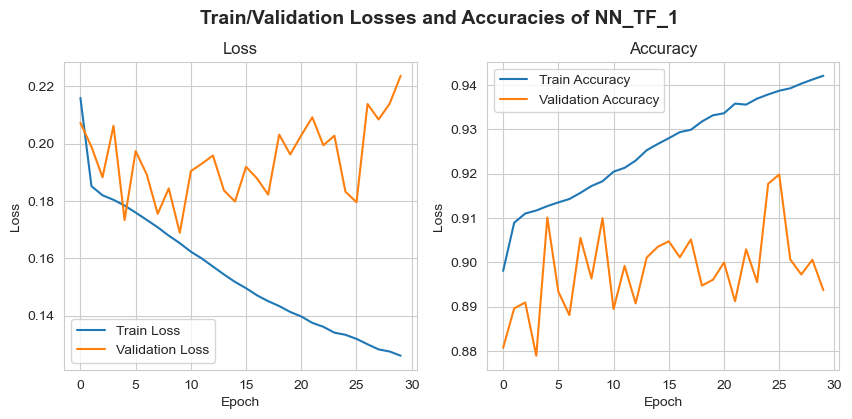

In [48]:
# Visualise the losses and accuracies
visualise_loss_accuracy(history_1.history, model_name)

The gaps between the train and validation curves show that the model is overfitting. We can add in some dropout layers to regularise the model.

**Model 4 - Neural Network (Tensorflow) - Add Dropout Layers to Reduce Overfitting**

In [49]:
# Set up for the modeling process
model_name = 'NN_TF_2'
model_path = os.path.join(model_folder, f'{model_name}.keras')

In [50]:
# For reproducible result
tf.keras.utils.set_random_seed(42)

# Create the model
nn_2 = Sequential()

# Add fully connected layers to extracte features
nn_2.add(Dense(16, activation='relu', input_shape=input_shape))
nn_2.add(Dropout(0.5))
nn_2.add(Dense(32, activation='relu'))
nn_2.add(Dropout(0.5))
nn_2.add(Dense(64, activation='relu'))
nn_2.add(Dropout(0.5))
nn_2.add(Dense(32, activation='relu'))
nn_2.add(Dropout(0.5))
nn_2.add(Dense(16, activation='relu'))
nn_2.add(Dropout(0.5))

# Final layer for prediction
nn_2.add(Dense(1, activation='sigmoid'))

In [51]:
# Compile the model
optimizer = Adam()
nn_2.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['acc'])

# Have a look at the architecture of the neural network
nn_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 16)                224       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_7 (Dense)             (None, 32)                544       
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 64)                2112      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 32)               

In [52]:
%%time
# Train the model
history_2 = nn_2.fit(X_train_up, y_train_up, epochs=30, validation_data=(X_val, y_val))

Epoch 1/30
3838/3838 [==============================] - 10s 2ms/step - loss: 0.3502 - acc: 0.8456 - val_loss: 0.1999 - val_acc: 0.9101
Epoch 2/30
3838/3838 [==============================] - 7s 2ms/step - loss: 0.2643 - acc: 0.8829 - val_loss: 0.1602 - val_acc: 0.9151
Epoch 3/30
3838/3838 [==============================] - 7s 2ms/step - loss: 0.2471 - acc: 0.8884 - val_loss: 0.1642 - val_acc: 0.9121
Epoch 4/30
3838/3838 [==============================] - 7s 2ms/step - loss: 0.2421 - acc: 0.8898 - val_loss: 0.1768 - val_acc: 0.8865
Epoch 5/30
3838/3838 [==============================] - 8s 2ms/step - loss: 0.2408 - acc: 0.8905 - val_loss: 0.1720 - val_acc: 0.8902
Epoch 6/30
3838/3838 [==============================] - 8s 2ms/step - loss: 0.2395 - acc: 0.8903 - val_loss: 0.1618 - val_acc: 0.9065
Epoch 7/30
3838/3838 [==============================] - 8s 2ms/step - loss: 0.2381 - acc: 0.8911 - val_loss: 0.1708 - val_acc: 0.8918
Epoch 8/30
3838/3838 [==============================] - 7s 2m

In [53]:
# Show the validation MAE score
print(f'The validation accuracy score of {model_name}: {history_2.history["val_acc"][-1]:.4f}')

The validation accuracy score of NN_TF_2: 0.9222


In [54]:
# Store the result
result[model_name] = {}
result[model_name]['val_acc'] = history_2.history["val_acc"][-1]
best_model[model_name] = nn_2

# Delete the model if it exists
if os.path.isfile(model_path):
    os.remove(model_path)

# Save the model
best_model[model_name].save(model_path)
if os.path.isfile(model_path):
    print(f'The {model_name} model has been saved.')

The NN_TF_2 model has been saved.


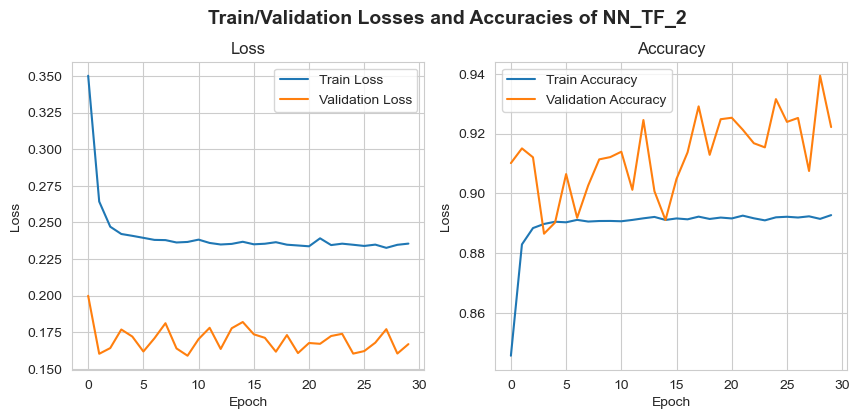

In [55]:
# Visualise the losses and accuracies
visualise_loss_accuracy(history_2.history, model_name)

The model has overcome the overfitting issue but the validation curves are spiky. Also, it is unusual that the validation result is better than the training result. This could be due to the imbalance classes. We have upsized the training set so that the classes are balanced but the validation set is still having imbalanced classes. The model might not be able to learn properly on the minority class and therefore the result is better on the validation set which has less minority class examples. We shall examine this reasoning in the model evaluation stage.

The spiky validation curve might due to a high learning rate. Let's schedule the learning rate and train more epochs to see if this issue can be solved.

**Model 5 - Neural Network (Tensorflow) - Schedule the Learning Rate and Train More Epochs**

In [56]:
# Set up for the modeling process
model_name = 'NN_TF_3'
model_path = os.path.join(model_folder, f'{model_name}.keras')

In [57]:
# For reproducible result
tf.keras.utils.set_random_seed(42)

# Create the model
nn_3 = Sequential()

# Add fully connected layers to extracte features
nn_3.add(Dense(16, activation='relu', input_shape=input_shape))
nn_3.add(Dropout(0.5))
nn_3.add(Dense(32, activation='relu'))
nn_3.add(Dropout(0.5))
nn_3.add(Dense(64, activation='relu'))
nn_3.add(Dropout(0.5))
nn_3.add(Dense(32, activation='relu'))
nn_3.add(Dropout(0.5))
nn_3.add(Dense(16, activation='relu'))
nn_3.add(Dropout(0.5))

# Final layer for prediction
nn_3.add(Dense(1, activation='sigmoid'))

In [58]:
# Compile the model
optimizer = Adam(learning_rate=0.001)
nn_3.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['acc'])

# Have a look at the architecture of the neural network
nn_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 16)                224       
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_13 (Dense)            (None, 32)                544       
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_14 (Dense)            (None, 64)                2112      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 32)               

In [59]:
# Define a stepwise exponential decay learning rate
def lr_schedule(epoch):
    current_lr = K.get_value(nn_3.optimizer.lr)
    factor = 0.3
    period = 10

    if (epoch > 0) and (epoch % period == 0) and (current_lr >= 1e-5):
        return current_lr * factor
    else:
        return current_lr

lr_scheduler = LearningRateScheduler(lr_schedule)

In [60]:
%%time
# Train the model
history_3 = nn_3.fit(X_train_up, y_train_up, epochs=60, validation_data=(X_val, y_val), callbacks=[lr_scheduler])

Epoch 1/60
3838/3838 [==============================] - 11s 2ms/step - loss: 0.3502 - acc: 0.8456 - val_loss: 0.1999 - val_acc: 0.9101 - lr: 0.0010
Epoch 2/60
3838/3838 [==============================] - 8s 2ms/step - loss: 0.2643 - acc: 0.8829 - val_loss: 0.1602 - val_acc: 0.9151 - lr: 0.0010
Epoch 3/60
3838/3838 [==============================] - 8s 2ms/step - loss: 0.2471 - acc: 0.8884 - val_loss: 0.1642 - val_acc: 0.9121 - lr: 0.0010
Epoch 4/60
3838/3838 [==============================] - 8s 2ms/step - loss: 0.2421 - acc: 0.8898 - val_loss: 0.1768 - val_acc: 0.8865 - lr: 0.0010
Epoch 5/60
3838/3838 [==============================] - 9s 2ms/step - loss: 0.2408 - acc: 0.8905 - val_loss: 0.1720 - val_acc: 0.8902 - lr: 0.0010
Epoch 6/60
3838/3838 [==============================] - 8s 2ms/step - loss: 0.2395 - acc: 0.8903 - val_loss: 0.1618 - val_acc: 0.9065 - lr: 0.0010
Epoch 7/60
3838/3838 [==============================] - 8s 2ms/step - loss: 0.2381 - acc: 0.8911 - val_loss: 0.1708 -

In [61]:
# Show the validation MAE score
print(f'The validation accuracy score of {model_name}: {history_3.history["val_acc"][-1]:.4f}')

The validation accuracy score of NN_TF_3: 0.9042


In [62]:
# Store the result
result[model_name] = {}
result[model_name]['val_acc'] = history_3.history["val_acc"][-1]
best_model[model_name] = nn_3

# Delete the model if it exists
if os.path.isfile(model_path):
    os.remove(model_path)

# Save the model
best_model[model_name].save(model_path)
if os.path.isfile(model_path):
    print(f'The {model_name} model has been saved.')

The NN_TF_3 model has been saved.


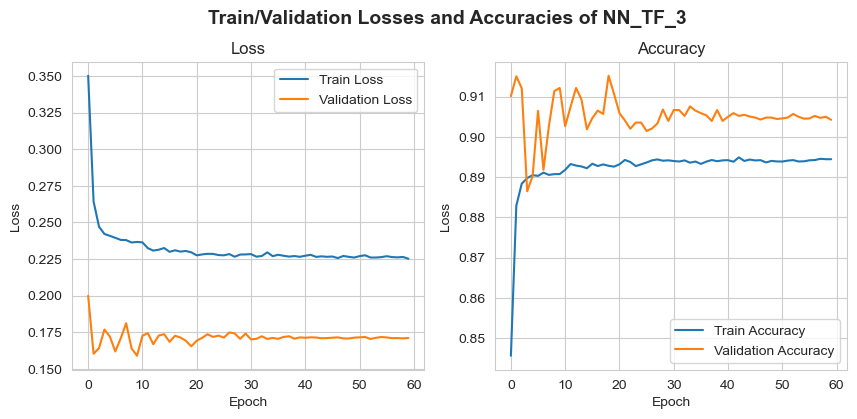

In [63]:
# Visualise the losses and accuracies
visualise_loss_accuracy(history_3.history, model_name)

The validation curves are still less spiky now. Let's recreate the model with the PyTorch framework.

**Model 6 - Neural Network (PyTorch)**

Let's recreate the model 5 in the PyTorch framework.

In [64]:
# Convert the data to tensor
X_train_pt = torch.tensor(X_train_up.values, dtype=torch.float32)
y_train_pt = torch.tensor(y_train_up.values, dtype=torch.float32)

X_val_pt = torch.tensor(X_val.values, dtype=torch.float32)
y_val_pt = torch.tensor(y_val.values, dtype=torch.float32)

X_test_pt = torch.tensor(X_test.values, dtype=torch.float32)
y_test_pt = torch.tensor(y_test.values, dtype=torch.float32)

In [65]:
# Set up for the modeling process
model_name = 'NN_PT_1'
model_path = os.path.join(model_folder, f'{model_name}.pt')

In [66]:
# Define the model
class torch_nn(nn.Module):
    def __init__(self):
        super().__init__()

        # Recreate the model 6
        self.layers = nn.Sequential(
            nn.Linear(in_features=X_train_pt.shape[1], out_features=16),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=16, out_features=32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=32, out_features=64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=32, out_features=16),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=16, out_features=1)
        )

    def forward(self, x):
        return self.layers(x)

In [67]:
# For reproducible result
np.random.seed(42)
torch.manual_seed(42)

# Create the model
nn_4 = torch_nn()

# Have a look at the architecture of the neural network
nn_4

torch_nn(
  (layers): Sequential(
    (0): Linear(in_features=13, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=16, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=32, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=64, out_features=32, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=32, out_features=16, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.5, inplace=False)
    (15): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [68]:
class MyLRScheduler(_LRScheduler):
    def __init__(self, optimizer, factor, period):      
        self.factor = factor
        self.period = period
        super().__init__(optimizer)
        
    def get_lr(self):
        current_lr = self.base_lrs[0]
        if (self.last_epoch > 0) and (self.last_epoch % self.period == 0) and (current_lr >= 1e-5):
            adjusted_lr = current_lr * self.factor
            self.base_lrs[0] = adjusted_lr
        return self.base_lrs

In [69]:
# Set up the optimizer and loss function
opt = torch.optim.Adam(nn_4.parameters(), lr=0.001)
loss_fn = nn.BCEWithLogitsLoss()

# Set up the lr scheduler with correct arguments
lr_scheduler_pt = MyLRScheduler(optimizer=opt, factor=0.3, period=10)

# Set up the accuracy function
acc_fn = Accuracy('binary')

In [70]:
%%time
# Set up the training batches
train_dataset = TensorDataset(X_train_pt, y_train_pt)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# To store the training history
history_4 = {
    'loss': [],
    'acc': [],
    'val_loss': [],
    'val_acc': []
}

# Set up the training loop
epochs = 60

for epoch in tqdm(range(epochs), desc=f'Training {model_name} model... '):       
    nn_4.train()
    train_loss = 0.0

    for X_batch, y_batch in train_loader:
        batch_logits = nn_4(X_batch).squeeze()
        loss = loss_fn(batch_logits, y_batch)
        train_loss += loss

        opt.zero_grad()
        loss.backward()
        opt.step()

    train_loss /= len(train_loader)

    nn_4.eval()
    with torch.inference_mode():
        y_logits = nn_4(X_train_pt).squeeze()
        y_pred = torch.round(torch.sigmoid(y_logits))
        train_acc = acc_fn(y_pred, y_train_pt)

        y_val_logits = nn_4(X_val_pt).squeeze()
        y_val_pred = torch.round(torch.sigmoid(y_val_logits))
        val_loss = loss_fn(y_val_logits, y_val_pt)
        val_acc = acc_fn(y_val_pred, y_val_pt)

    # Store the current learning_rate to print
    current_lr = opt.param_groups[0]['lr']
    
    # Adjust the learning rate if needed
    lr_scheduler_pt.step()

    # Store the result
    history_4['loss'].append(train_loss.item())
    history_4['acc'].append(train_acc.item())
    history_4['val_loss'].append(val_loss.item())
    history_4['val_acc'].append(val_acc.item())

    # Print the result for every 5 epochs
    if (epoch+1) % 5 == 0 or epoch == 0:
        print(f'Epoch {epoch+1} loss: {train_loss:.4f} | acc: {train_acc:.4f} | ', end='')
        print(f'val_loss: {val_loss:.4f} | val_acc: {val_acc:.4f} | lr: {current_lr}')

Training NN_PT_1 model... :   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 1 loss: 0.3136 | acc: 0.8946 | val_loss: 0.2109 | val_acc: 0.8825 | lr: 0.001
Epoch 5 loss: 0.2403 | acc: 0.9022 | val_loss: 0.2019 | val_acc: 0.8635 | lr: 0.001
Epoch 10 loss: 0.2377 | acc: 0.9049 | val_loss: 0.2014 | val_acc: 0.8861 | lr: 0.001
Epoch 15 loss: 0.2318 | acc: 0.9037 | val_loss: 0.1906 | val_acc: 0.8731 | lr: 0.0003
Epoch 20 loss: 0.2313 | acc: 0.9046 | val_loss: 0.1875 | val_acc: 0.8765 | lr: 0.0003
Epoch 25 loss: 0.2299 | acc: 0.9020 | val_loss: 0.1883 | val_acc: 0.8968 | lr: 8.999999999999999e-05
Epoch 30 loss: 0.2299 | acc: 0.9041 | val_loss: 0.1891 | val_acc: 0.8678 | lr: 8.999999999999999e-05
Epoch 35 loss: 0.2291 | acc: 0.9038 | val_loss: 0.1875 | val_acc: 0.8662 | lr: 2.6999999999999996e-05
Epoch 40 loss: 0.2296 | acc: 0.9042 | val_loss: 0.1869 | val_acc: 0.8672 | lr: 2.6999999999999996e-05
Epoch 45 loss: 0.2283 | acc: 0.9042 | val_loss: 0.1879 | val_acc: 0.8667 | lr: 8.099999999999999e-06
Epoch 50 loss: 0.2280 | acc: 0.9041 | val_loss: 0.1874 | val_acc: 0.

In [71]:
# Show the validation MAE score
print(f'The validation accuracy score of {model_name}: {history_4["val_acc"][-1]:.4f}')

The validation accuracy score of NN_PT_1: 0.8656


In [72]:
# Store the result
result[model_name] = {}
result[model_name]['val_acc'] = history_4["val_acc"][-1]
best_model[model_name] = nn_4

# Delete the model if it exists
if os.path.isfile(model_path):
    os.remove(model_path)

# Save the model
torch.save(nn_4.state_dict(), model_path)
if os.path.isfile(model_path):
    print(f'The {model_name} model has been saved.')

The NN_PT_1 model has been saved.


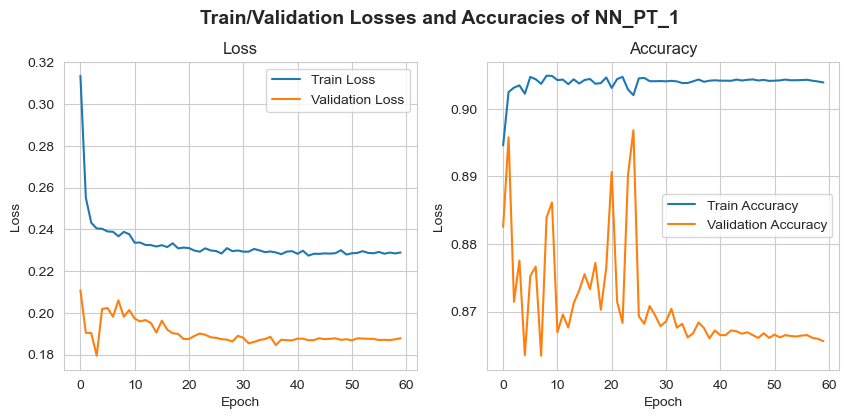

In [73]:
# Visualise the losses and accuracies
visualise_loss_accuracy(history_4, model_name)

The result is differ from that of the model in TensorFlow framework. The validation loss is still better than the training loss but the validation accuracy score is worse than the training accuracy score. This could be due to the different initialised parameters in the two frameworks.

[Back to Contents](#back)

## 6. Model Evaluation <a id='evaluation'></a>

In [74]:
# Store the confusion matrices
cm = {}

# Evaluate models
for model_name in result.keys():
    if model_name == 'NN_PT_1':
        nn_4.eval()
        with torch.inference_mode():
            y_test_pred = torch.round(torch.sigmoid(nn_4(X_test_pt).squeeze()))
            result[model_name]['test_acc'] = acc_fn(y_test_pred, y_test_pt).item()
            cm_pt = ConfusionMatrix('binary')
            cm[model_name] = cm_pt(y_test_pred, y_test_pt)
    elif model_name == 'LightGBM':
        y_test_pred = best_model[model_name].predict(X_test_lgbm)
        result[model_name]['test_acc'] = accuracy_score(y_test, y_test_pred)
        cm[model_name] = confusion_matrix(y_test, y_test_pred)
    elif 'keras' in str(type(best_model[model_name])):
        y_test_pred = tf.round(best_model[model_name].predict(X_test))
        result[model_name]['test_acc'] = accuracy_score(y_test, y_test_pred)
        cm[model_name] = confusion_matrix(y_test, y_test_pred)
    else:
        y_test_pred = best_model[model_name].predict(X_test)
        result[model_name]['test_acc'] = accuracy_score(y_test, y_test_pred)
        cm[model_name] = confusion_matrix(y_test, y_test_pred)

451/451 [==============================] - 0s 893us/step


In [75]:
# Have a look at the final result
result_df = pd.DataFrame(result).transpose().sort_values('test_acc', ascending=False)
result_df

,val_acc,test_acc
LightGBM,0.960130,0.962211
NN_TF_2,0.922202,0.924560
NN_TF_3,0.904244,0.908612
NN_TF_1,0.893704,0.890653
LogisticRegression,0.882610,0.888642
NN_PT_1,0.865622,0.871308


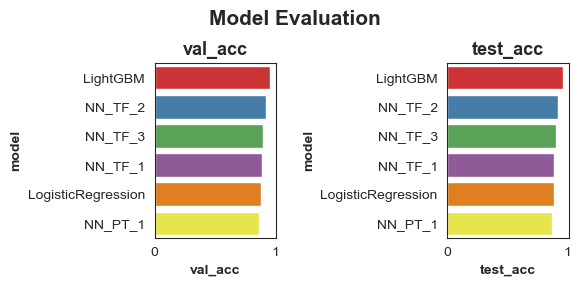

In [76]:
# Visualise the final result
plot_results = result_df.columns
nrows, ncols = 1, 2

sns.set_style('white')
fig, axs = plt.subplots(nrows, ncols, figsize=(6, 3))

plt.suptitle('Model Evaluation', fontsize=15, fontweight='bold', y=0.94)

# Assign colors for models
colors = sns.color_palette('Set1')
model_colors = {}
for i, model in enumerate(result_df.index):
    color = colors[i % len(colors)]
    model_colors[model] = color

for i in range(ncols):
    plot_name = plot_results[i]
    plot_data = result_df[[plot_name]].sort_values(plot_name, ascending=False)

    ax = axs[i]
    sns.barplot(y=plot_data.index, x=plot_data[plot_name], palette=model_colors, hue=plot_data.index, ax=ax)        
    ax.set_title(plot_name, fontsize=13, fontweight='bold')
    ax.set_xlabel(plot_name, fontweight='bold')
    ax.set_ylabel('model', fontweight='bold')
        
plt.tight_layout()
plt.show()

The LightGBM model have both the highest validation and test accuracies.

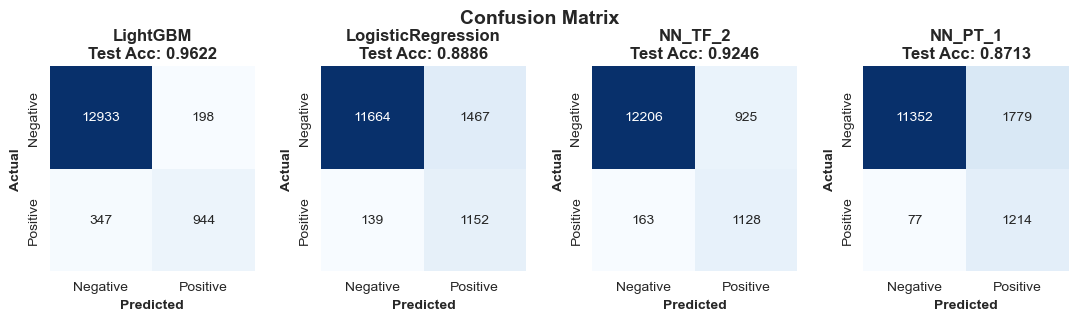

In [77]:
fig, axs = plt.subplots(1, 4, figsize=(11, 3))
fig.suptitle('Confusion Matrix', fontsize=14, fontweight='bold')

plot_titles = ['LightGBM', 'LogisticRegression', 'NN_TF_2', 'NN_PT_1']

for i, plot_title in enumerate(plot_titles):
    ax = axs[i]
    sns.heatmap(cm[plot_title], annot=True, fmt='.0f', square=True, cmap='Blues', cbar=False, ax=ax)
    ax.set_title(f'{plot_title}\nTest Acc: {result_df.loc[f"{plot_title}", "test_acc"]:.4f}', fontsize=12, fontweight='bold')
    ax.set_ylabel('Actual', fontweight='bold')
    ax.set_xlabel('Predicted', fontweight='bold')
    ax.set_xticks([0.5, 1.5], ['Negative', 'Positive'])
    ax.set_yticks([0.5, 1.5], ['Negative', 'Positive'])
    
plt.tight_layout()
plt.show()

As expected, the neural network models do not perform well in predicting the minority class.

[Back to Contents](#back)

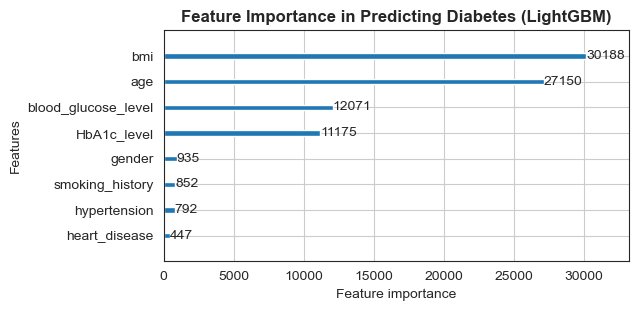

In [78]:
# Check the feature importance of lightgbm model
plot_importance(best_model['LightGBM'], figsize=(6, 3))
plt.title('Feature Importance in Predicting Diabetes (LightGBM)', fontweight='bold')
plt.show()

The `bmi` and `age` are the most important features in predicting the diabetes, follow by the `blood_glucose_level` and `HbA1c_level`.

[Back to Contents](#back)

## 7. Conclusion <a id='conclusion'></a>

The dataset contains 100000 examples which record the basic health information of individuals and whether the individuals have diabetes. The dataset is clean and do not need any preprocessing. A total of six models have been developed to predict the flight ticket prices. Surprisingly, the neural network model in PyTorch framework has the worst accuracy scores, we might need to reconsider the model architecture for better performance. On the other hand, the lightgbm model has the best accuracy scores as it perform better in predicting the minority class.